# Импорты

In [1]:
import os
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import time
import pylab as pl
from IPython import display
import math
from pathlib import Path
from utils import SQDIFF_GRAY, load_patterns, split_cards
from main import Recongnizer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from dataset_builder import prepare_cards

# Объявление путей

In [2]:
HOME_PATH = "/Users/16692350/Projects/Poker"
DATA_PATH = os.path.join(HOME_PATH, "data")
PATTERN_PATH = os.path.join(HOME_PATH, "patterns/types")
CARD_PATH = "/Users/16692350/Projects/PokerPython/cards"
RANK_PATH = "/Users/16692350/Projects/PokerPython/rank"
SUIT_PATH = "/Users/16692350/Projects/PokerPython/suit"

# Functions

In [3]:
# IMAGE_SIZE_X = 60
# IMAGE_SIZE_Y = 80
# X_POS = 1
# Y_POS = 0
# SHIFT_Y=25


def draw_result(image, x, y, color="red"):
    plt.figure()
    plt.imshow(image)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect = Rectangle((x,y),18,18,linewidth=1,edgecolor=color,facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()


def draw_patternts(pattern):
    fig = plt.figure() 
    rows = 1
    columns = len(pattern)

    for index, (key, values) in enumerate(pattern.items()):
        a = fig.add_subplot(rows, columns, index+1)
        a.title.set_text(key)
        # imgplot = plt.imshow(values)
        imgplot = plt.imshow(values, cmap=plt.get_cmap('gray'))

# Dataset preparation

In [5]:
prepare_cards(DATA_PATH, CARD_PATH, RANK_PATH, SUIT_PATH, clean=True)

100%|█████████████████████████████████████████| 361/361 [00:09<00:00, 37.39it/s]


# Init data

In [7]:
# filename = "2c3dAh.png"
filename = "7dJc6sAh5s.png"
image_path = os.path.join(DATA_PATH, filename)

## Load patterns

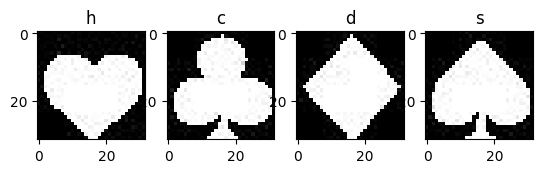

In [8]:
suit_patternts = load_patterns(os.path.join(SUIT_PATH, "*.jpg"))
draw_patternts(suit_patternts)

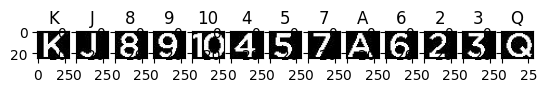

In [9]:
rank_patternts = load_patterns(os.path.join(RANK_PATH, "*.jpg"))
draw_patternts(rank_patternts)

## Load cards on table

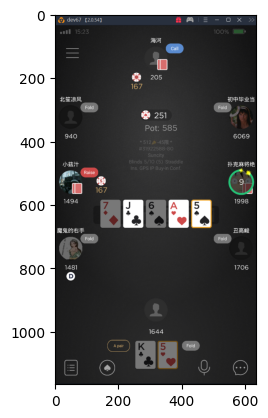

In [10]:
image = np.asarray(Image.open(image_path))
imgplot = plt.imshow(image)

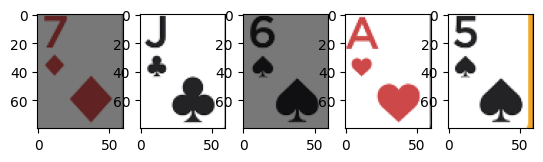

In [20]:
estimator = Recongnizer(None, None)
card_list = estimator.find_cards(image, size_x=estimator.card_size_x, size_y=estimator.card_size_y, grey=False)

fig = plt.figure() 
rows = 1
columns = len(card_list)

for index, card in enumerate(card_list):
    fig.add_subplot(rows, columns, index+1)
    imgplot = plt.imshow(card)

# Search

In [21]:
fig = plt.figure() 
rows = 1
columns = len(card_list)

for index, card in enumerate(card_list):
    max_ccorr, x_best, y_best, typeName, ccorr_list_best = recognizeCard(card, patternts)
    print(f"Label {typeName}, max_ccorr {max_ccorr}, x {x_best}, y {y_best}")
    draw_result(card, x_best, y_best)
    fig.add_subplot(rows, columns, index+1)

NameError: name 'recognizeCard' is not defined

<Figure size 640x480 with 0 Axes>

# Повышение яркости

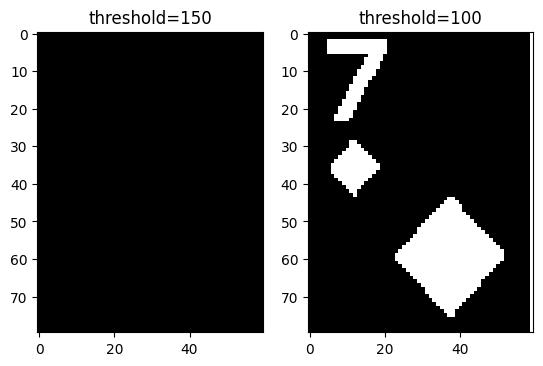

In [33]:
card = card_list[0]
fig = plt.figure()

grey_card = Recongnizer(None, None).rgb2gray(card, inverse=True, threshold=150)
a = fig.add_subplot(1, 2, 1)
a.title.set_text("threshold=150")
plt.imshow(grey_card, cmap=plt.get_cmap('gray'))

grey_card = Recongnizer(None, None).rgb2gray(card, inverse=True, threshold=100)
a = fig.add_subplot(1, 2, 2)
a.title.set_text("threshold=100")
plt.imshow(grey_card, cmap=plt.get_cmap('gray'))

# Валидация алгоритма

In [34]:
suit_patterns = load_patterns(os.path.join(SUIT_PATH, "*.jpg"))
rank_patterns = load_patterns(os.path.join(RANK_PATH, "*.jpg"))
estimator = Recongnizer(suit_patterns, rank_patterns)
files = glob.glob(os.path.join(DATA_PATH, "*.png"))
target = []
prediction_list = []
for file in tqdm(files):
    image = np.asarray(Image.open(file))
    result = estimator.recognize(image)
    card_labels = [val[0] + val[1] for val in split_cards(file)]
    for index, target_label in enumerate(card_labels):
        target.append(target_label)
        if index < len(result):
            prediction_list.append(result[index]["label"])
        else:
            prediction_list.append("NaN")
            print(file)
print(f"F1: {f1_score(target, prediction_list, average='micro')}")

100%|█████████████████████████████████████████| 361/361 [00:45<00:00,  7.97it/s]

F1: 1.0


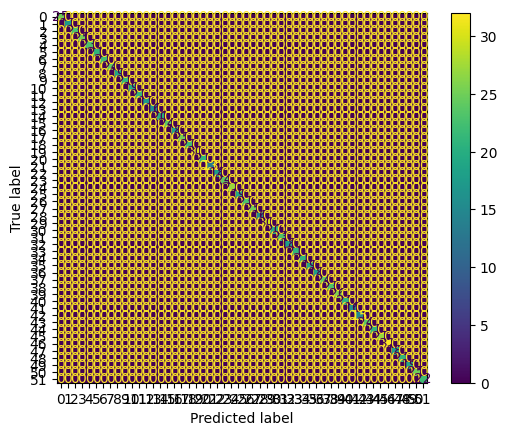

In [35]:
cm = confusion_matrix(target, prediction_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Проверка работы алгоритма только на картах

100%|███████████████████████████████████████████| 52/52 [00:02<00:00, 21.82it/s]


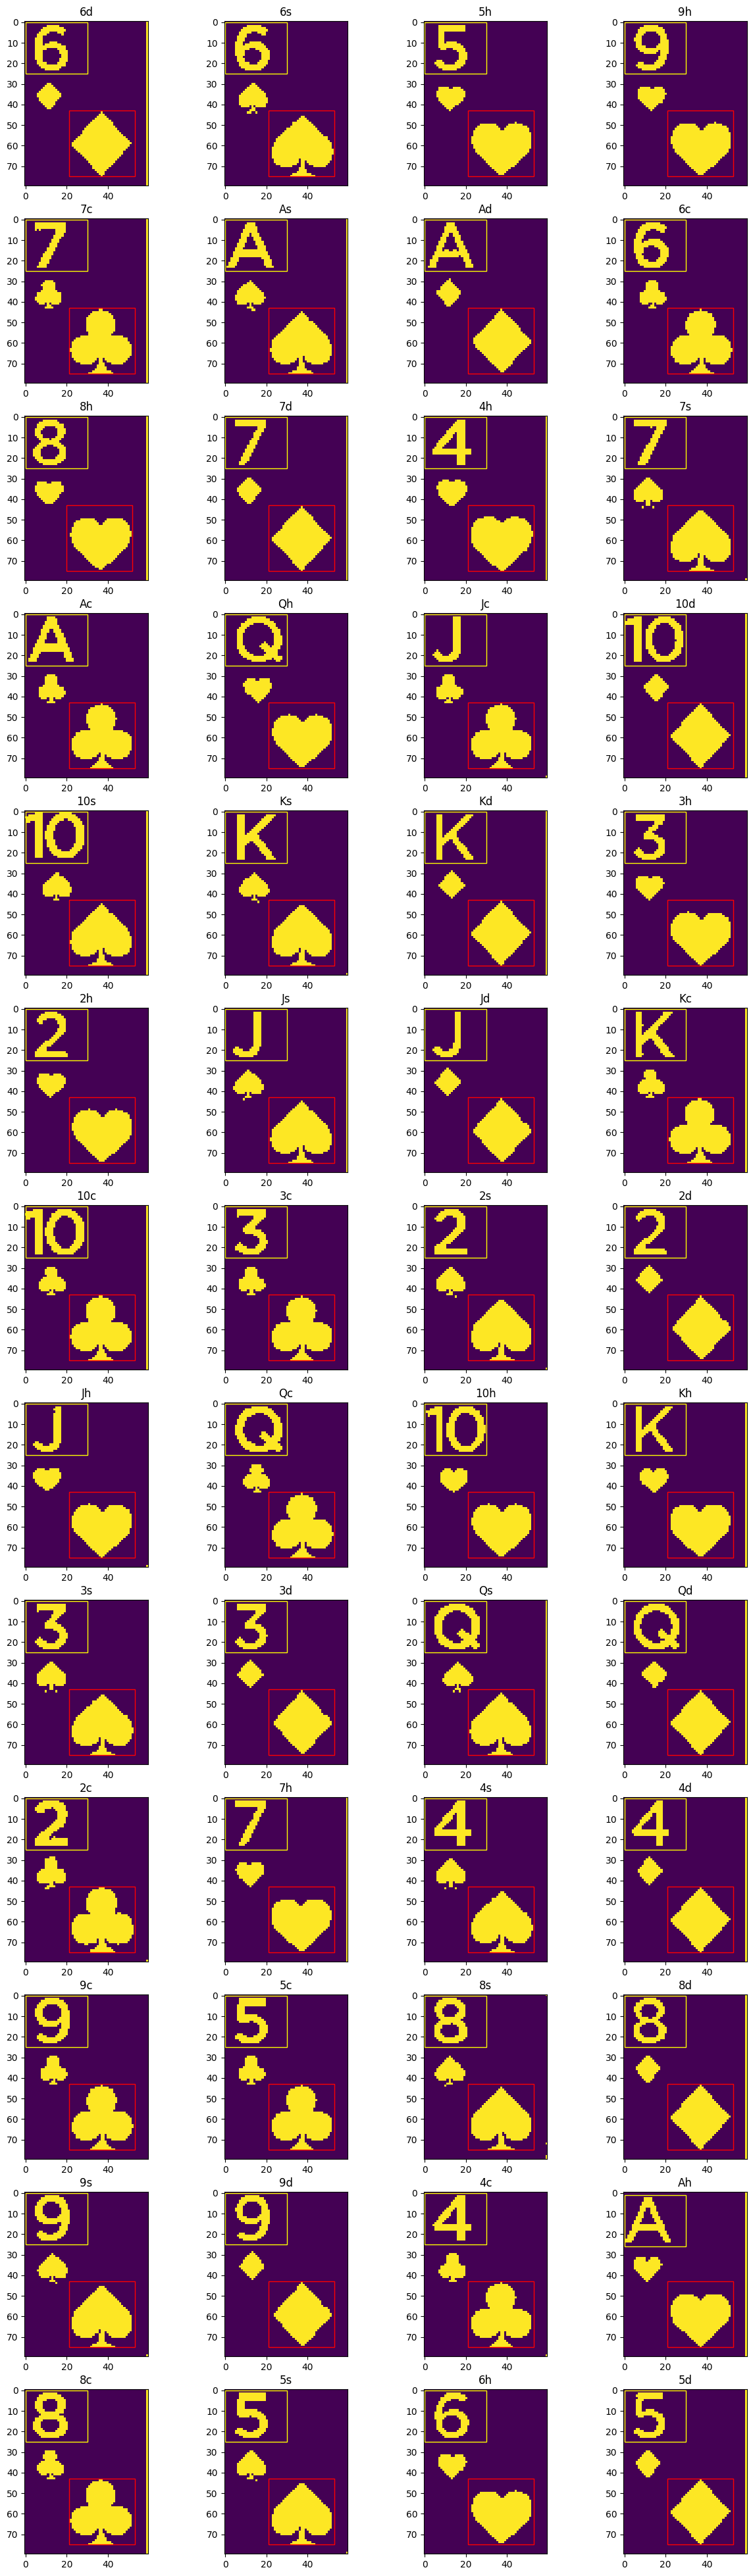

In [42]:
files = glob.glob(os.path.join(CARD_PATH, "*.jpg"))
target_value = []
actual_value = []

rank_target_value=[]
rank_actual_value = []

# SHIFT_Y = 25
SHIFT_Y = 43
SHIFT_X = 19

fig = plt.figure(figsize=(15, 50)) 
rows = 13
columns = 4
index = 1


suit_patterns = load_patterns(os.path.join(SUIT_PATH, "*.jpg"))
rank_patterns = load_patterns(os.path.join(RANK_PATH, "*.jpg"))
estimator = Recongnizer(suit_patterns, rank_patterns)

for file_path in tqdm(files):
    rectangles = []
    card = np.asarray(Image.open(file_path))

    for threshold in [150, 100]:
        grey_card = estimator.rgb2gray(card,inverse=True, threshold=threshold)
        if np.sum(grey_card) != grey_card.shape[0] * grey_card.shape[1] * 255:
            card = grey_card
            break
    
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    
    max_ccorr, x_best, y_best, typeName, ccorr_list_best = estimator.recognizeCard(card[SHIFT_Y:, SHIFT_X:], suit_patternts, SQDIFF_GRAY())
    rectangles.append({"x": x_best + SHIFT_X, "y":y_best + SHIFT_Y, "color": "red", "window_size_x": 32, "window_size_y": 32})
    target_value.append(base_name[-1])
    actual_value.append(typeName[0])
    

    max_ccorr, x_best, y_best, rankName, ccorr_list_best = estimator.recognizeCard(card[:50, :40], rank_patternts, SQDIFF_GRAY())
    rectangles.append({"x": x_best, "y":y_best, "color": "yellow", "window_size_x": 30, "window_size_y": 25})
    rank_target_value.append(base_name[0:-1])
    rank_actual_value.append(rankName)

    ax = fig.add_subplot(rows, columns, index)
    plt.imshow(card)
    ax = plt.gca()
    ax.title.set_text(f"{rankName}{typeName}")
    for record in rectangles:
        rect = Rectangle((record["x"],record["y"]),record["window_size_x"],record["window_size_y"],linewidth=1,edgecolor=record["color"],facecolor='none')
        ax.add_patch(rect)

    index += 1


plt.show()

In [43]:
f1_score(target_value, actual_value, average="micro")

1.0

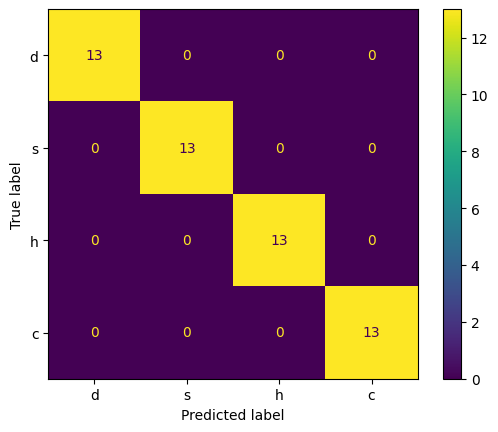

In [44]:
labesl = ["d", "s", "h", "c"]
cm = confusion_matrix(target_value, actual_value, labels=labesl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labesl)
disp.plot()
plt.show()

In [45]:
f1_score(rank_target_value, rank_actual_value, average="micro")

1.0

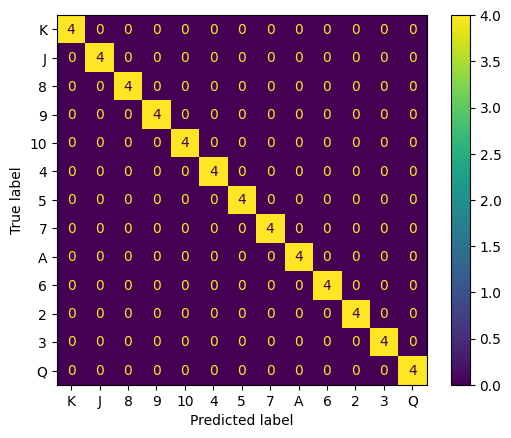

In [46]:
labesl = list(rank_patternts.keys())
cm = confusion_matrix(rank_target_value, rank_actual_value, labels=labesl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labesl)
disp.plot()
plt.show()